In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ea3aed0130>,
 'tobs': 18.3,
 'id': 0,
 'date': '2010-01-01',
 'prcp': 2.0,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
# Convert list of tuples into normal list
recent_date = list(np.ravel(recent_date))[0]
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')
recent_date.day

23

2016-08-23


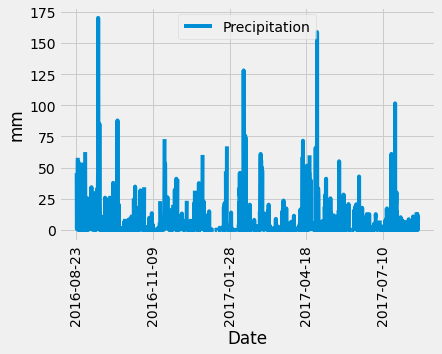

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from sqlalchemy import desc



# Calculate the date one year from the last date in data set.
year_ago = dt.date(recent_date.year, recent_date.month, recent_date.day)\
     - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores

year_data = session.query(measurement.date, measurement.prcp ).\
     filter(measurement.date >= year_ago)#.order_by(measurement.date,desc).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_data_df = pd.DataFrame(year_data, columns=['Date', 'Precipitation'])
year_data_df.set_index('Date', inplace=True)


# Sort the dataframe by date
year_data_df = year_data_df.sort_values(by='Date')
year_data_df.head()


# Use Pandas Plotting with Matplotlib to plot the data
year_data_df.plot(rot=90)
plt.ylabel('mm')
plt.savefig("../Images/precipitation.png")
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_data_df.describe()



,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ea3af17cd0>,
 'latitude': 21.2716,
 'id': 0,
 'elevation': 0.914,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [13]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).count()
total_stations


9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_act_stn = active_stations[0][0]
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = session.query(func.min(measurement.tobs), func.max(measurement.tobs),\
     func.avg(measurement.tobs)).filter(measurement.station == most_act_stn).all()
print(f"Most Active Station's ID: {most_act_stn}")
print(f"Most Active Station's Lowest Temperature: {temp[0][0]}")
print(f"Most Active Station's Highest Temperature: {temp[0][1]}")
print(f"Most Active Station's Average Temperature: {round(temp[0][2], 2)}")

Most Active Station's ID: USC00519281
Most Active Station's Lowest Temperature: 12.2
Most Active Station's Highest Temperature: 29.4
Most Active Station's Average Temperature: 22.04


In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs).\
    filter(measurement.station == most_act_stn).\
    filter(measurement.date >= year_ago).all()


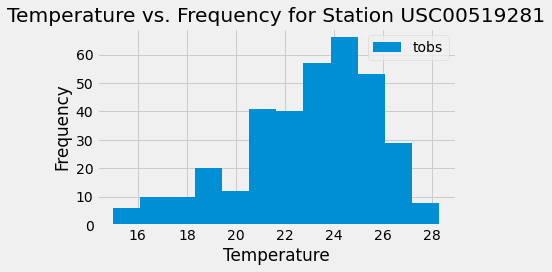

In [17]:
#plot the results as a histogram
temp_df = pd.DataFrame(temp_data, columns=['tobs'])
temp_df.plot.hist(bins=12)
plt.title(f"Temperature vs. Frequency for Station {most_act_stn}")
plt.xlabel("Temperature")
plt.tight_layout()
plt.savefig("../Images/station-histogram.png")
plt.show()


# Close session

In [18]:
# Close Session
session.close()